In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''expand + depthwise + pointwise + squeeze-excitation'''

    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1,
                          stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

        # SE layers
        self.fc1 = nn.Conv2d(out_planes, out_planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(out_planes//16, out_planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        shortcut = self.shortcut(x) if self.stride == 1 else out
        # Squeeze-Excitation
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = self.fc2(w).sigmoid()
        out = out * w + shortcut
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(cfg[-1][1], num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def EfficientNetB0():
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 2),
           (6,  24, 2, 1),
           (6,  40, 2, 2),
           (6,  80, 3, 2),
           (6, 112, 3, 1),
           (6, 192, 4, 2),
           (6, 320, 1, 2)]
    return EfficientNet(cfg)


def test():
    net = EfficientNetB0()
    x = torch.randn(2, 3, 32, 32)
    y = net(x)
    print(y.shape)

In [0]:
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


# _, term_width = os.popen('stty size', 'r').read().split()
term_width = 80
term_width = int(term_width)

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [3]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import numpy as np

# from models import *
# from utils import progress_bar


# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
# args = parser.parse_args()

lr = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


# trainset.targets***************************************************************
import random
length = len(trainset.targets)
percentage_corruption = 20
n = length*percentage_corruption/100
corrupt_classes = np.random.randint(0,10,int(n))
# print(np.unique(corrupt_idx))
corrupt_idx = random.sample(range(0,length), int(n))
# print(len(corrupt_idx) , len(np.unique(corrupt_idx)))
# print(corrupt_idx)
# print(len(corrupt_classes))
a = np.array(trainset.targets)
a[corrupt_idx] = corrupt_classes
trainset.targets = list(a)
#**********************************************************************************

testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
# net = VGG('VGG19')
# net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
net = EfficientNetB0()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# if args.resume:
#     # Load checkpoint.
#     print('==> Resuming from checkpoint..')
#     assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
#     checkpoint = torch.load('./checkpoint/ckpt.pth')
#     net.load_state_dict(checkpoint['net'])
#     best_acc = checkpoint['acc']
#     start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

train_acc =[]
test_acc=[]
epoch_list=[]
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

#         progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print("train accuracy ", correct/total ,train_loss)
    train_acc.append(train_loss)

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

#             progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print("test accuracy ", correct/total , test_loss)
    test_acc.append(test_loss)

    # Save checkpoint.
#     acc = 100.*correct/total
#     if acc > best_acc:
#         print('Saving..')
#         state = {
#             'net': net.state_dict(),
#             'acc': acc,
#             'epoch': epoch,
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, './checkpoint/ckpt.pth')
#         best_acc = acc


for epoch in range(start_epoch, start_epoch+220):
    epoch_list.append(epoch)
    train(epoch)
    test(epoch)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
train accuracy  0.29802 778.6562894582748
test accuracy  0.4448 156.5143746137619

Epoch: 1
train accuracy  0.38938 706.4438925981522
test accuracy  0.5032 142.58235275745392

Epoch: 2
train accuracy  0.43278 672.9813531637192
test accuracy  0.5426 134.4097055196762

Epoch: 3
train accuracy  0.46724 645.5228077173233
test accuracy  0.5926 121.41951024532318

Epoch: 4
train accuracy  0.49562 622.58396089077
test accuracy  0.6145 116.21778452396393

Epoch: 5
train accuracy  0.51644 604.7235660552979
test accuracy  0.6479 110.45844340324402

Epoch: 6
train accuracy  0.53446 587.3899703025818
test accuracy  0.6531 107.57328015565872

Epoch: 7
train accuracy  0.55288 572.6322139501572
test accuracy  0.6961 95.78554481267929

Epoch: 8
train accuracy  0.56544 559.1094213724136
test accuracy  0.703 96.04043424129486

Epoch: 9
train accuracy  0.58036 547.2590819001198


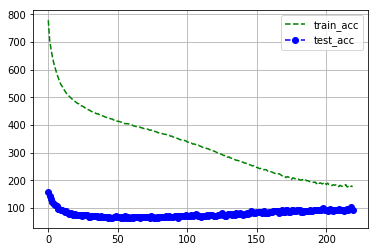

In [4]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot(epoch_list, train_acc, 'g--' , label='train_acc')
plt.plot(epoch_list, test_acc, 'bo--', label = 'test_acc')
plt.grid()
plt.legend()
plt.show()

In [5]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
import random
length = len(testset.targets)
percentage_corruption = 20
n = length*percentage_corruption/100
corrupt_classes = np.random.randint(0,10,int(n))
# print(np.unique(corrupt_idx))
corrupt_idx = random.sample(range(0,length), int(n))
print(len(corrupt_idx) , len(np.unique(corrupt_idx)))
print(corrupt_idx)
print(len(corrupt_classes))

st1 = testset.targets
a = np.array(testset.targets)
a[corrupt_idx] = corrupt_classes
testset.targets = list(a)
st2 = testset.targets

print(st1 == st2)

Files already downloaded and verified
2000 2000
[6728, 9743, 4955, 9413, 4407, 5704, 2322, 6262, 3524, 8998, 5318, 6421, 5195, 5018, 3932, 2903, 2624, 4353, 5302, 3492, 2130, 8636, 1393, 5029, 9930, 3641, 432, 9950, 6061, 1603, 7139, 777, 4750, 4369, 9199, 2383, 8397, 2985, 3087, 3877, 4657, 2942, 5268, 5811, 6589, 3393, 3835, 59, 2870, 3196, 9680, 22, 5612, 9517, 3356, 1581, 7489, 1062, 4495, 7536, 7668, 9751, 6776, 873, 7855, 1921, 5343, 7438, 5406, 9508, 6002, 5322, 2243, 745, 5190, 5460, 5367, 9471, 9881, 3778, 9431, 6478, 1666, 8222, 3820, 6784, 8035, 8355, 2813, 1340, 3150, 2023, 4027, 8977, 5173, 8427, 6322, 1412, 5321, 2990, 9183, 5326, 4180, 7210, 1108, 7581, 6370, 7918, 8443, 5111, 21, 8975, 283, 2760, 5036, 6351, 5265, 1149, 7470, 2213, 4436, 8053, 4625, 370, 5847, 3340, 2788, 2152, 2655, 8595, 9054, 7620, 5547, 1883, 2125, 4928, 5632, 534, 3780, 8052, 2273, 9193, 819, 3493, 9966, 1869, 986, 457, 816, 919, 9395, 9896, 2792, 8607, 2420, 6360, 5167, 5915, 5629, 1994, 704, 2644

In [6]:
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
global best_acc
net.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

#             progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
print("test accuracy ", correct/total , test_loss)
test_acc.append(test_loss)

test accuracy  0.6107 190.9880999326706
